In [2]:
import requests
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import yfinance as yf

In [7]:

def setup_session():
    """Set up a requests session with appropriate headers."""
    session = requests.Session()
    session.headers.update({
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)",
        "Accept": "application/json, text/javascript, */*; q=0.01",
        "Referer": "https://www.nseindia.com/"
    })
    session.get("https://www.nseindia.com")
    return session


def fetch_nifty50_data(session):
    """Fetch NIFTY 50 data from NSE API."""
    url = "https://www.nseindia.com/api/equity-stockIndices?index=NIFTY%2050"
    response = session.get(url)
    response.raise_for_status()
    data = response.json()
    return data['data']


def process_nifty_data(data):
    """Process NIFTY 50 data into a dictionary."""
    nse_details = {}
    symbols = []

    for item in data:
        symbol = item['symbol']
        if symbol == "NIFTY 50":
            continue
        symbols.append(symbol)
        nse_details[symbol] = {
            "LTP": item.get('lastPrice'),
            "Volume": item.get('totalTradedVolume'),
            "%Change": item.get('pChange'),
            "52W_High": item.get('yearHigh'),
            "52W_Low": item.get('yearLow'),
            "Day_High": item.get('dayHigh'),
            "Day_Low": item.get('dayLow')
        }
    return symbols, nse_details


def fetch_stock_info(symbols):
    """Fetch stock info such as PE, EPS, and Market Cap from Yahoo Finance."""
    info_data = {}
    for sym in symbols:
        yahoo_symbol = sym + ".NS"
        try:
            stock = yf.Ticker(yahoo_symbol)
            info = stock.info
        except Exception:
            info = {}
        info_data[sym] = {
            "PE": info.get('trailingPE', np.nan),
            "EPS": info.get('trailingEps', np.nan),
            "Market_Cap": info.get('marketCap', np.nan)
        }
    return info_data


def calculate_returns(symbol):
    """Calculate 6-month, 1-year, and 5-year returns for a stock."""
    yahoo_symbol = symbol + ".NS"
    end = datetime.now()
    start_5y = end - timedelta(days=5 * 365)
    try:
        df_yf = yf.download(yahoo_symbol, start=start_5y, end=end, progress=False)
    except Exception:
        return None, None, None

    if df_yf.empty:
        return None, None, None

    current_price = df_yf['Adj Close'].iloc[-1]

    # 6-month return
    start_6m = end - timedelta(days=182)
    df_6m = df_yf[df_yf.index >= start_6m]
    ret_6m = None
    if not df_6m.empty:
        old_6m = df_6m['Adj Close'].iloc[0]
        ret_6m = ((current_price - old_6m) / old_6m) * 100

    # 1-year return
    start_1y = end - timedelta(days=365)
    df_1y = df_yf[df_yf.index >= start_1y]
    ret_1y = None
    if not df_1y.empty:
        old_1y = df_1y['Adj Close'].iloc[0]
        ret_1y = ((current_price - old_1y) / old_1y) * 100

    # 5-year return
    old_5y = df_yf['Adj Close'].iloc[0]
    ret_5y = ((current_price - old_5y) / old_5y) * 100

    return ret_6m, ret_1y, ret_5y


def fetch_returns(symbols):
    """Fetch returns data for all symbols."""
    returns_data = {}
    for sym in symbols:
        returns_data[sym] = calculate_returns(sym)
    return returns_data


def create_dataframe(symbols, nse_details, info_data, returns_data):
    """Combine all data into a Pandas DataFrame."""
    all_rows = []
    for sym in symbols:
        rets = returns_data[sym]

        row = {
            "Symbol": sym,
            "LTP": nse_details[sym].get("LTP"),
            "Volume": nse_details[sym].get("Volume"),
            "%Change": nse_details[sym].get("%Change"),
            "PE": info_data[sym].get("PE"),
            "EPS": info_data[sym].get("EPS"),
            "Market_Cap": info_data[sym].get("Market_Cap"),
            "52W_High": nse_details[sym].get("52W_High"),
            "52W_Low": nse_details[sym].get("52W_Low"),
            "Upper_Circuit": nse_details[sym].get("Day_High"),
            "Lower_Circuit": nse_details[sym].get("Day_Low"),
            "6M_Return%": rets[0] if rets else np.nan,
            "1Y_Return%": rets[1] if rets else np.nan,
            "5Y_Return%": rets[2] if rets else np.nan
        }

        all_rows.append(row)
    return pd.DataFrame(all_rows)


# Main Script
if __name__ == "__main__":
    # Step 1: Set up session and fetch data
    session = setup_session()
    nifty_data = fetch_nifty50_data(session)

    # Step 2: Process NIFTY data
    symbols, nse_details = process_nifty_data(nifty_data)

    # Step 3: Fetch additional info and calculate returns
    info_data = fetch_stock_info(symbols)
    returns_data = fetch_returns(symbols)

    # Step 4: Create and display the final DataFrame
    df = create_dataframe(symbols, nse_details, info_data, returns_data)
    print(df)


        Symbol       LTP    Volume  %Change          PE     EPS  \
0   BHARTIARTL   1682.00  12900707     4.44   81.283226   20.69   
1          ITC    471.00  31753858     2.26   28.658537   16.40   
2    KOTAKBANK   1804.90   3893531     2.05   16.474909  109.60   
3   HINDUNILVR   2391.25   2260902     1.97   54.643350   43.74   
4   ULTRACEMCO  12082.35    408880     1.90   53.190865  227.18   
5        TITAN   3511.00   1242351     1.89   96.159220   36.49   
6    POWERGRID    334.10  14973536     1.49   19.919450   16.76   
7      HCLTECH   1965.00   2569918     1.49   31.744598   62.02   
8    NESTLEIND   2255.00    554661     1.39   72.999670   30.87   
9       GRASIM   2696.05    412267     1.35   39.838734   67.59   
10  ADANIPORTS   1259.70   2818291     1.26   26.525263   47.50   
11   ICICIBANK   1345.45  13536684     1.22   20.324920   66.17   
12    HDFCLIFE    633.15   2573194     1.05   80.682396    7.84   
13        SBIN    861.90   9379370     0.96   10.741179   80.2

Question 2

In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t, norm

[*********************100%***********************]  1 of 1 completed


Volume Stats:
 {'mean': Ticker
ITC.NS    1.130691e+07
dtype: float64, 'std_dev': Ticker
ITC.NS    7.246335e+06
dtype: float64, 'z_critical': 1.959963984540054, 't_critical': 1.9697743954258793, 'margin_of_error_z': Ticker
ITC.NS    909225.495442
dtype: float64, 'margin_of_error_t': Ticker
ITC.NS    913776.536057
dtype: float64, 'ci_z': (Ticker
ITC.NS    1.039769e+07
dtype: float64, Ticker
ITC.NS    1.221614e+07
dtype: float64), 'ci_t': (Ticker
ITC.NS    1.039313e+07
dtype: float64, Ticker
ITC.NS    1.222069e+07
dtype: float64)}

Close Price Stats:
 {'mean': Ticker
ITC.NS    408.529362
dtype: float64, 'std_dev': Ticker
ITC.NS    39.707341
dtype: float64, 'z_critical': 1.959963984540054, 't_critical': 1.9697743954258793, 'margin_of_error_z': Ticker
ITC.NS    4.982232
dtype: float64, 'margin_of_error_t': Ticker
ITC.NS    5.00717
dtype: float64, 'ci_z': (Ticker
ITC.NS    403.54713
dtype: float64, Ticker
ITC.NS    413.511594
dtype: float64), 'ci_t': (Ticker
ITC.NS    403.522192
dtype: float

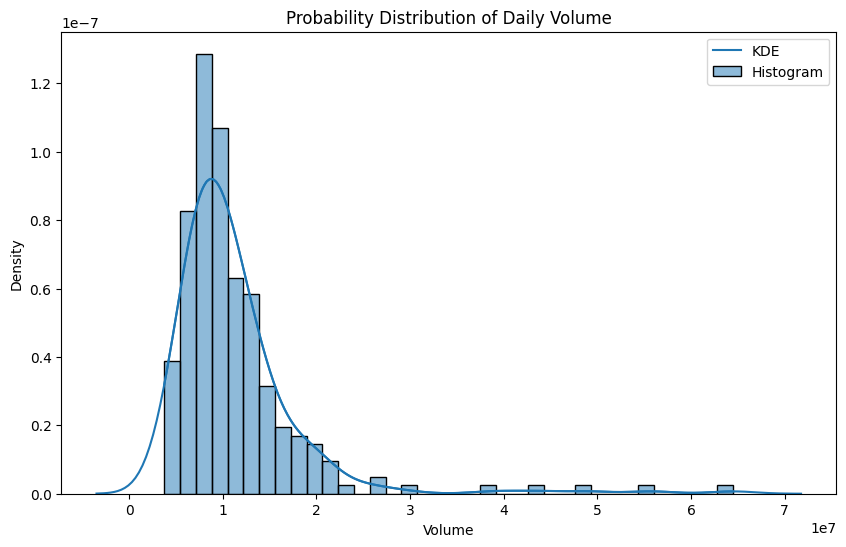

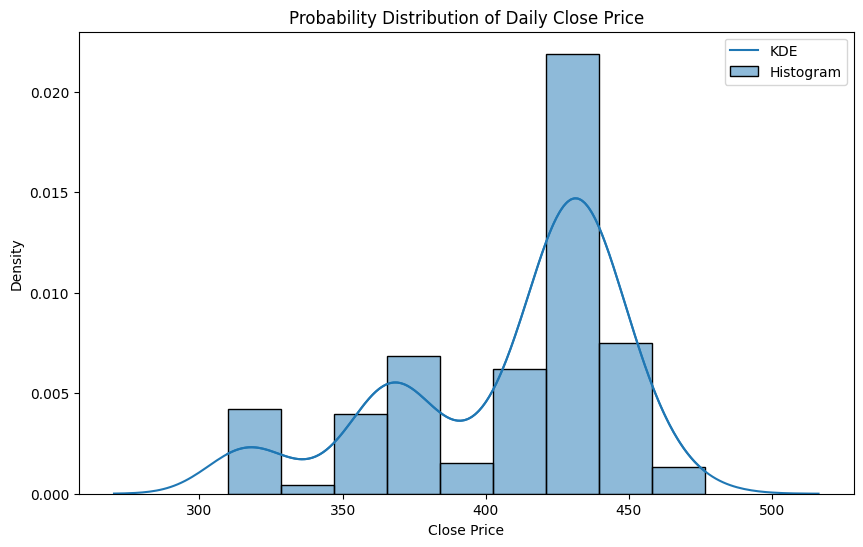

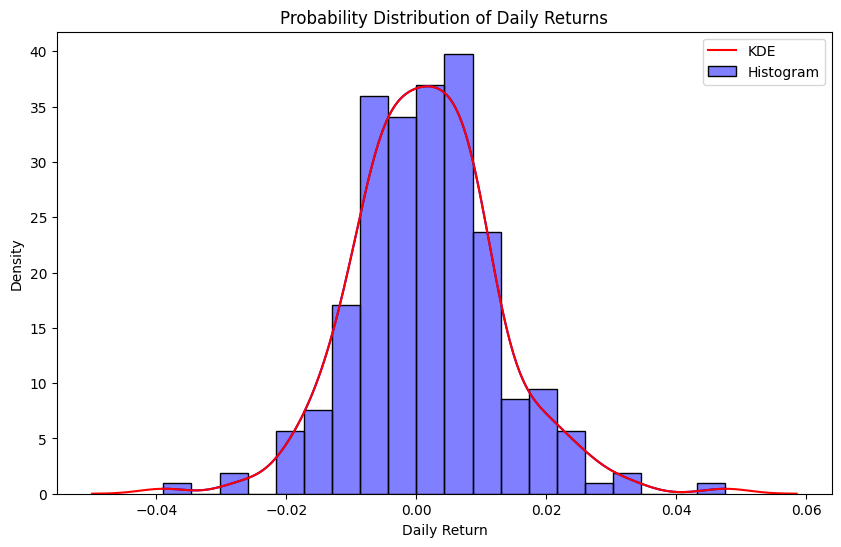


Summary Statistics:
          Metric                                          Mean  \
0        Volume  Ticker
ITC.NS    1.130691e+07
dtype: float64   
1   Close Price    Ticker
ITC.NS    408.529362
dtype: float64   
2  Daily Return                                      0.001495   

                             Standard Deviation  \
0  Ticker
ITC.NS    7.246335e+06
dtype: float64   
1     Ticker
ITC.NS    39.707341
dtype: float64   
2                                      0.010971   

                                       95% CI (Z)  \
0    ([10397685.594722232], [12216136.585605638])   
1       ([403.547129645854], [413.5115944292133])   
2  (0.0001181218776102166, 0.0028712615830923044)   

                                       95% CI (T)  
0    ([10393134.554106941], [12220687.626220929])  
1      ([403.522191561646], [413.53653251342126])  
2  (0.00011123158984219987, 0.002878151870860321)  


In [6]:

stock_ticker = 'ITC.NS'
start_date = '2023-01-01'
end_date = '2023-12-31'

data = yf.download(stock_ticker, start=start_date, end=end_date)

data['Daily Return'] = data['Adj Close'].pct_change()

clean_data = data.dropna()

def calculate_statistics(series, confidence=0.95):
    """
    Calculate the mean, standard deviation, t-score, z-score, and confidence interval for a given data series.
    """
    n = len(series)
    mean = series.mean()
    std_dev = series.std()

    z_critical = norm.ppf((1 + confidence) / 2)

    t_critical = t.ppf((1 + confidence) / 2, df=n-1)

    margin_of_error_z = z_critical * (std_dev / np.sqrt(n))
    margin_of_error_t = t_critical * (std_dev / np.sqrt(n))

    ci_z = (mean - margin_of_error_z, mean + margin_of_error_z)
    ci_t = (mean - margin_of_error_t, mean + margin_of_error_t)

    return {
        'mean': mean,
        'std_dev': std_dev,
        'z_critical': z_critical,
        't_critical': t_critical,
        'margin_of_error_z': margin_of_error_z,
        'margin_of_error_t': margin_of_error_t,
        'ci_z': ci_z,
        'ci_t': ci_t
    }

volume_stats = calculate_statistics(clean_data['Volume'])
close_stats = calculate_statistics(clean_data['Adj Close'])
return_stats = calculate_statistics(clean_data['Daily Return'].dropna())

print("Volume Stats:\n", volume_stats)
print("\nClose Price Stats:\n", close_stats)
print("\nDaily Return Stats:\n", return_stats)

def plot_distribution(series, title, xlabel):
    """
    Plot the probability distribution of a given series using Seaborn.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(series, kde=True, color='blue', stat="density", label="Histogram")
    sns.kdeplot(series, color='red', label="KDE")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Density")
    plt.legend()
    plt.show()

plot_distribution(clean_data['Volume'], "Probability Distribution of Daily Volume", "Volume")
plot_distribution(clean_data['Adj Close'], "Probability Distribution of Daily Close Price", "Close Price")
plot_distribution(clean_data['Daily Return'].dropna(), "Probability Distribution of Daily Returns", "Daily Return")

summary_stats = pd.DataFrame({
    'Metric': ['Volume', 'Close Price', 'Daily Return'],
    'Mean': [volume_stats['mean'], close_stats['mean'], return_stats['mean']],
    'Standard Deviation': [volume_stats['std_dev'], close_stats['std_dev'], return_stats['std_dev']],
    '95% CI (Z)': [volume_stats['ci_z'], close_stats['ci_z'], return_stats['ci_z']],
    '95% CI (T)': [volume_stats['ci_t'], close_stats['ci_t'], return_stats['ci_t']]
})

print("\nSummary Statistics:\n", summary_stats)